In [106]:
from collections import defaultdict
from copy import deepcopy

from Bio import SeqIO
from Bio.SeqRecord import SeqRecord

from graphviz import Digraph
from tqdm import tqdm

In [101]:
class Edge:
    def __init__(self, n1, n2, seq):
        self.out_node = n1
        self.in_node = n2
        self.seq = seq   # (на самом деле содержит список к-меров в порядке прохода)
        
    def __hash__(self):
        return hash(str(seq))
    
    def __repr__(self):
        return f'Edge(out={self.out_node}, in={self.in_node}, seq={self.seq})'
    
class DeBruijnGraph:
    def __init__(self, k=55, min_edge_length=100, min_edge_coverage=100):
        self.k = k
        self.min_edge_length = min_edge_length
        self.min_edge_coverage = min_edge_coverage
        
        self.node_counter = 0
        
        self.nodes = set()
        
        self.kmer_encode = {}  # кмер: число
        self.kmer_decode = {}  # число: кмер
        self.kmer_coverage = defaultdict(int)
        
        self.adj_list_in = defaultdict(list)
        self.adj_list_out = defaultdict(list)
        
        self.edges = defaultdict(dict)
        
        self.label = ""
    
    def filename(self):
        """Возвращает имя (последнего) файла (без расширения), по которому был построен граф"""
        return '.'.join(self.label.split('.')[:-1])
        
    def read_file(self, path, extension='fasta'):
        """Добавляет в граф вершины и рёбра по заданному файлу"""
        self.label = path
        with open(path, 'r') as f:
            for rec in tqdm(SeqIO.parse(f, extension)):
                self.read_string(rec.seq)
                self.read_string(rec.seq.reverse_complement())
        
    def read_string(self, seq):
        edge_length = self.k + 1
        for i in range(len(seq) - edge_length + 1):
            edge_seq = seq[i:i+edge_length]
            source_seq = edge_seq[:-1]
            sink_seq = edge_seq[1:]
            
            for kmer in (source_seq, sink_seq):
                if kmer not in self.kmer_encode.keys():
                    self.kmer_encode[kmer] = self.node_counter
                    self.kmer_decode[self.node_counter] = kmer
                    self.node_counter += 1
                    
            source_id = self.kmer_encode[source_seq]
            sink_id = self.kmer_encode[sink_seq]
            
            self.adj_list_out[source_id].append(sink_id)
            self.adj_list_in[sink_id].append(source_id)
            
            self.kmer_coverage[sink_id] += 1
            self.kmer_coverage[source_id] += 1
            
            self.nodes.add(source_id)
            self.nodes.add(sink_id)
            
            edge = Edge(source_id, sink_id, [source_id, sink_id])
            self.edges[source_id][sink_id] = edge
            
    def compress(self):
        # Рекурсия не завелась, поэтому бродим в цикле до тех пор, 
        # пока будет нечего больше сжимать
        flag = True
        while flag:
            for node in self.nodes:
                if len(set(self.adj_list_in[node])) == len(set(self.adj_list_out[node])) == 1:
                    # строим новое ребро
                    new_source = next(iter(self.adj_list_in[node]))
                    new_sink = next(iter(self.adj_list_out[node]))
                    old_edge1 = self.edges[new_source].pop(node)
                    old_edge2 = self.edges.pop(node)[new_sink]
                    new_edge = Edge(new_source, new_sink, old_edge1.seq + old_edge2.seq[1:])
                    self.edges[new_source][new_sink] = new_edge
                    
                    # удаляем отовсюду срединную вершину
                    self.nodes.remove(node)
                    
                    self.adj_list_out[new_source].append(new_sink)
                    self.adj_list_out[new_source] = self.remove_node(node, self.adj_list_out[new_source]) 
                    
                    self.adj_list_in[new_sink].append(new_source)
                    self.adj_list_in[new_sink] = self.remove_node(node, self.adj_list_in[new_sink]) 
                    
                    self.adj_list_in.pop(node)
                    self.adj_list_out.pop(node)
                    
                    break
            if self.is_compressed():
                flag = False
        self.remove_lonesome_nodes()
        
    def is_compressed(self):
        """Проверяет, остались ли ещё вершины со степенями 1"""
        for node in self.nodes:
            if len(set(self.adj_list_in[node])) == len(set(self.adj_list_out[node])) == 1:
                return False
        return True
    
    def remove_loose_ends(self):
        """Удаляет короткие и малопокрытые концевые рёбра"""
        for node in list(self.nodes):
            indegree = len(set(self.adj_list_in[node]))
            outdegree = len(set(self.adj_list_out[node]))
            # если входящая или исходящая степень равна единице...
            if indegree + outdegree == 1:
            
                if indegree == 1:
                    source = self.adj_list_in[node][0]
                    edge = self.edges[source][node]
                    length = len(edge.seq) + self.k - 1
                    coverage = self.mean_edge_coverage(edge.seq)
                    
                    if length < self.min_edge_length or coverage < self.min_edge_coverage:
                        self.nodes.remove(node)
                        self.adj_list_in.pop(node)
                        self.adj_list_out[source] = self.remove_node(node, self.adj_list_out[source])
                        self.edges[source].pop(node)
                        
                elif outdegree == 1:
                    sink = self.adj_list_out[node][0]
                    edge = self.edges[node][sink]
                    length = len(edge.seq) + self.k - 1
                    coverage = self.mean_edge_coverage(edge.seq)
                    
                    if length < self.min_edge_length or coverage < self.min_edge_coverage:
                        self.nodes.remove(node)
                        self.adj_list_out.pop(node)
                        self.adj_list_in[sink] = self.remove_node(node, self.adj_list_in[sink])
                        self.edges.pop(node)
        # возможно теперь получится сильнее сжать граф...    
        self.compress()
        
    def remove_bad_edges(self):
        for source, sinks in list(self.edges.items()):
            for sink, edge in list(sinks.items()):
                coverage = self.mean_edge_coverage(edge.seq)
                length = len(edge.seq) + self.k - 1
                if length < self.min_edge_length or coverage < self.min_edge_coverage:
                    self.edges[source].pop(sink)
                    self.adj_list_out[source] = self.remove_node(sink, self.adj_list_out[source])
                    self.adj_list_in[sink] = self.remove_node(source, self.adj_list_in[sink])
        self.compress()
                
    def remove_lonesome_nodes(self):
        """Удаляет вершины со степенями 0"""
        for node in list(self.nodes):
            indegree = len(self.adj_list_in[node])
            outdegree = len(self.adj_list_out[node])
            if indegree == outdegree == 0:
                self.nodes.remove(node)
                if node in self.adj_list_in.keys():
                    self.adj_list_in.pop(node)
                if node in self.adj_list_out.keys():
                    self.adj_list_out.pop(node)
                if node in self.edges.keys():
                    self.edges.pop(node)
    
    def edges_to_fasta(self):
        edge_counter = 1
        seq_records = []
        for source, sinks in self.edges.items():
            for sink, edge in sinks.items():
                seq_records.append(SeqRecord(id=self.filename() + "-" + str(edge_counter),
                                  seq=self.reconstruct_seq(edge.seq), description=''))
        SeqIO.write(seq_records, self.filename() + '.fasta', 'fasta')
                
    def make_dot_graph(self, filename):
        dot = Digraph()
        for source, sinks in self.edges.items():
            dot.node(str(source))
            for sink, edge in sinks.items():
                dot.node(str(sink))
                dot.edge(str(source), str(sink), 
                label=f'Length = {len(edge.seq) + self.k - 1};\n Coverage = {self.mean_edge_coverage(edge.seq)}')
        dot.render(filename + '.gv')
        return dot 
    
    def reconstruct_seq(self, kmer_codes):
        """
        Возвращает последовательность, восстановленную по списку 
        кодов к-меров, содержащихся в ребре
        """
        seq = self.kmer_decode[kmer_codes[0]]
        for code in kmer_codes[1:]:
            seq += self.kmer_decode[code][-1]
        return seq

    def mean_edge_coverage(self, seq):
        total = sum(self.kmer_coverage[kmer] for kmer in seq)
        return round(total / len(seq), 2)
    
    @staticmethod
    def remove_node(node_code, node_list):
        """Удаляет все вхождения в список вершины с кодом node_code"""
        return list(filter(lambda x: x != node_code, node_list))
        
    
# G = DeBruijnGraph()

# G.read_string(seq)
# G.read_file('ECOLI_IS220_QUAKE_1K_paired_reads.fasta', extension='fasta')
# G.read_file('s_6.first10000.fastq', 'fastq')
# G.compress()
# dot = G.make_dot_graph()
#G.edges_to_fasta()

# G.remove_loose_ends()
#G.remove_bad_edges()
#G.make_dot_graph('test')

# 1 Сжатый граф без фильтрации рёбер

In [102]:
G = DeBruijnGraph()
G.read_file('s_6.first10000.fastq', 'fastq')
G.compress()

56320it [00:29, 1908.96it/s]


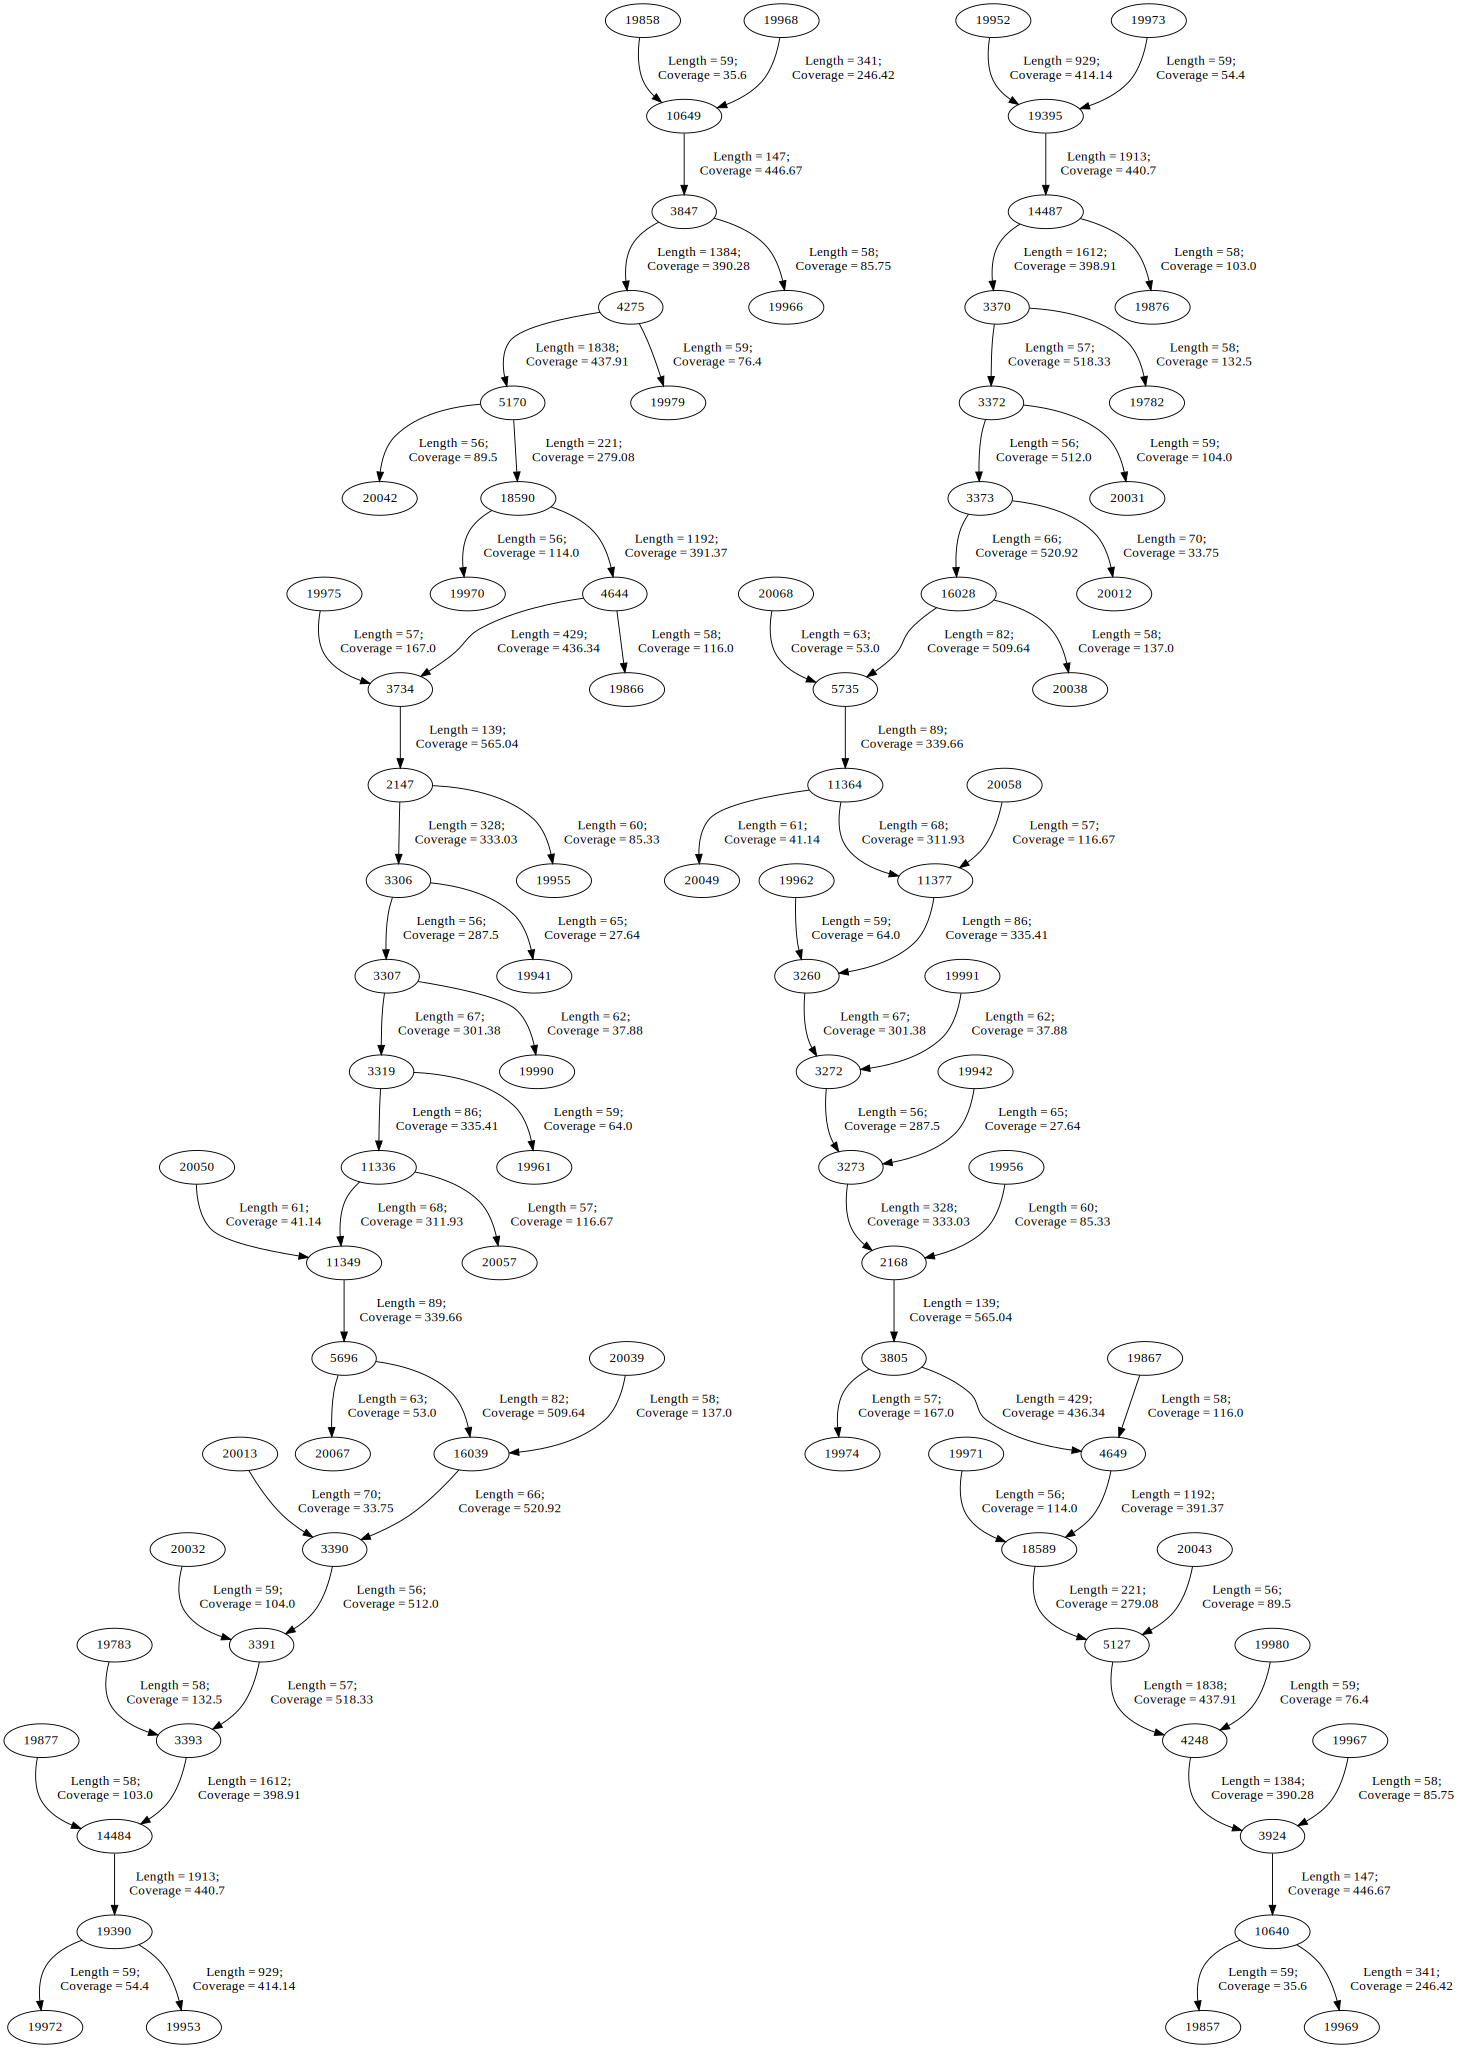

In [103]:
G.make_dot_graph('unfiltered')

# 2 Удаление "тупиковых" рёбер низкой длины и покрытия
Пороговые значения и для длины, и для покрытия равны 100

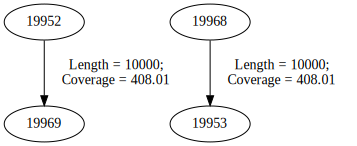

In [104]:
G_le = deepcopy(G)
G_le.remove_loose_ends()
G_le.make_dot_graph('no_loose_ends')

# 3 Удаление любых рёбер низкой длины и покрытия
Пороговые значения и для длины, и для покрытия равны 100

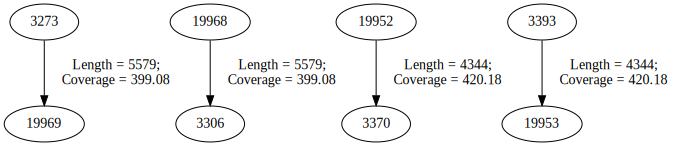

In [105]:
G_all = deepcopy(G)
G_all.remove_bad_edges()
G_all.make_dot_graph('no_bad_edges')